In [1]:
#불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 함께 불러

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 : ', (len(data)))

전체 샘플수 :  98401


# 데이터 전처리하기 (추상적 요약)

In [3]:
#null값 존재하는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* null값 없음

In [4]:
data.sample(10)

,headlines,text
86310,Release date of Lipstick Under My Burkha annou...,"Lipstick Under My Burkha, which was initially ..."
49670,Sky is the limit for India-US ties: US envoy,"As two democracies sharing common values, the ..."
57349,"Adobe achieves pay equality between men, women...",American software maker Adobe announced that i...
15468,I have a name: Tanushree on being called 'surv...,Reacting to Priyanka Chopra calling her a sexu...
53553,"China bans steel exports to N Korea, caps crud...",China has banned steel and other metal exports...
23939,Garry Sobers got out on duck in his career's o...,"West Indies' cricketing legend Garry Sobers, w..."
23029,Wish I knew what drew me to films that I picke...,"Aamir Khan, while talking about the films that..."
74623,UK MP resigns over her 'Pak men rape white gir...,Labour MP Sarah Champion has resigned as the s...
59031,Facebook rolls out AI-based tools to detect su...,Facebook on Monday said that it is rolling out...
64774,Punjab to close 800 govt schools with less tha...,The Punjab government has decided to close 800...


* 열이 두 개인 것 확인

In [5]:
#데이터의 중복 샘플 유무를 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 : ', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 : ', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 :  98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 :  98280


* 두 열 모두 중복 데이터가 있는 것 확인

In [6]:
#drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거
#inplace = True로 설정하면 dataframe 타입 값을 return하지 않고 data내부를 직접적으로 바꾼다
data.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 : ', (len(data)))

전체 샘플수 :  98280


In [7]:
#drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거
#inplace = True로 설정하면 dataframe 타입 값을 return하지 않고 data내부를 직접적으로 바꾼다
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 : ', (len(data)))

전체 샘플수 :  98262


## 텍스트 정규화와 불용어 제거

* 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 : ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', '

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있ek. 이를 사용하여 불용어를 제거할 것이다.

불용어를 제거하는 파트는 Text 전처리 시에서만 호출하고, 이미 상대적으로 문장 길이가 짧은 headlines을  전처리할 때는 호출하지 않도록 한다. 그리고, 짧다는 이유 뿐만 아니라 기사 헤드라인에서는 의미를 강조하기 위해 일부러 줄임말 쓰지 않고 풀어서 쓰는 경우가 있으니 불용어 제거는 하지 않는다.

In [10]:

#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() #텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    #불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) >1)
    
    #불용어 미제거 (summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) >1)
    return tokens
print('슝')

슝


* text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자

In [11]:
#먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력
clean_text = []
#전체 text데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
#전처리 후 출력
print('Text 전처리 후 결과: ', clean_text[:5])


Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

* headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어주자.

In [12]:
clean_headlines = []
#전체 summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    
print('headlines 전처리 후 결과: ', clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


* 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장하자. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체 해보자

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

#빈 값을 Null값으로 변환
data.replace('', np.nan, inplace = True)
print('슝')

슝


In [14]:
#Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

* null 없는 것 확인
## 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


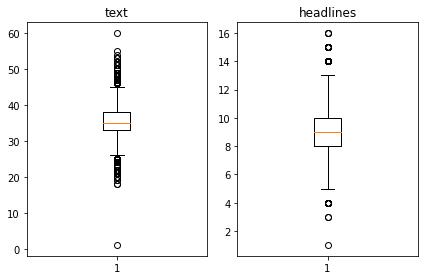

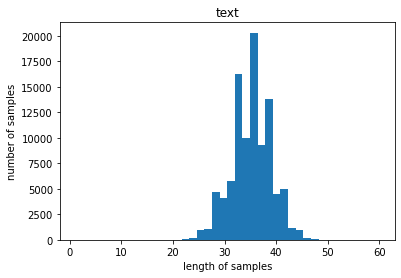

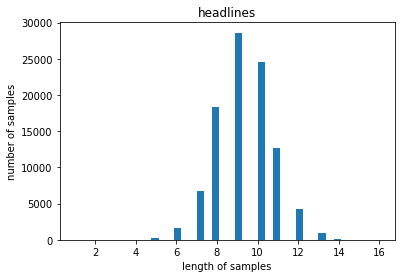

In [15]:
#샘플의 최대 길이 정하기
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40) #40개 단위로 끊어서 출력
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 박스플롯과 히스토그램으로 임의의 text, headlines의 최대길이를 임의로 정해보자

In [16]:
#text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.
text_max_len = 40
headlines_max_len = 11


* 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자

In [17]:
#길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 
#통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될것.
#훈련 데이터와 샘플의 길이를 입력하면, 
#데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    

* 이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.

In [18]:
#만든 함수 text, headlines에 적용
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92383627444994
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9450041725183692


* 길이 조정이 나쁘지 않은 것 같다. 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하자.

In [19]:
data = data[data['text'].apply(lambda x : len(x.split())  <= text_max_len)]
data = data[data['headlines'].apply(lambda x : len(x.split()) <= headlines_max_len)]
print('전체 샘플 수: ', (len(data)))

전체 샘플 수:  85756


## 시작 토큰과 종료 토큰 추가하자
* 각 토큰의 앞뒤에 붙여야할 띄어쓰기를 조심하자...

In [20]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [21]:
#디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) #인코더의 입력
decoder_input = np.array(data['decoder_input']) #디코더의 입력
decoder_target = np.array(data['decoder_target']) #디코더의 레이블
print('슝')

슝


훈련 데이터와 테스트 데이터를 분리

encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어주자

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[19566 30109  7186 ... 36896 24452 79954]


정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 될것

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('슝')

슝


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 주자

In [24]:
#테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수: ', n_of_val)

테스트 데이터의 수:  17151


정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하자

In [25]:
#정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수: ', len(encoder_input_train))
print('훈련 레이블의 개수: ', len(decoder_input_train))
print('테스트 데이터의 개수: ', len(encoder_input_test))
print('테스트 레이블의 개수: ', len(decoder_input_test))



훈련 데이터의 개수:  68605
훈련 레이블의 개수:  68605
테스트 데이터의 개수:  17151
테스트 레이블의 개수:  17151


훈련 데이터와 테스트 데이터가 각각 68605개와 17151개로 잘 분리되었다.

## 정수 인코딩

In [26]:
# encoder_input_train에 대해서 단어 집합만들기
#Keras의 토크나이저 이용해서 입력된 훈련데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [27]:
#등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
#src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있음
# ->통계적인 정보를 얻을 수 있음

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64553
등장 빈도가 6번 이하인 희귀 단어의 수: 43970
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20583
단어 집합에서 희귀 단어의 비율: 68.11457252180378
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7734996995009693


희귀 단어 등장 빈도 매우 낮으니 제외하자. 
단어 집합의 크기를 어림잡아 20000이라고 하자.

In [28]:
#토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한하기
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[12, 1953, 4702, 1810, 3442, 278, 7385, 1713, 19211, 112, 2498, 278, 955, 1954, 57, 955, 1811, 3, 18014, 203, 9, 19211, 2187, 5180, 1048, 318, 591, 7385, 422, 278], [151, 11, 12, 238, 2720, 3162, 3201, 1964, 44, 238, 470, 261, 965, 270, 796, 512, 58, 44, 238, 2758, 11510, 18015, 1913, 917, 1819, 265, 442, 7494, 1, 2720, 3996, 470, 261], [699, 476, 501, 56, 14107, 739, 7495, 2169, 2734, 2561, 2721, 143, 1948, 1250, 1959, 5181, 894, 1558, 1232, 645, 417, 508, 6016, 352, 2579, 32, 1, 501, 6, 39, 894, 1684, 2368]]


In [30]:
#summary데이터에도 텍스트 시퀀스를 정수 시퀀스로 변환하자
#decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [31]:
#등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28520
등장 빈도가 5번 이하인 희귀 단어의 수: 18813
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9707
단어 집합에서 희귀 단어의 비율: 65.96423562412342
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.176947021668832


희귀 단어 등장 빈도 매우 낮으니 제외하자. 단어 집합의 크기를 어림잡아 9000이라고 하자.

In [32]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 411, 47, 2354, 8166, 165, 1021, 5, 681], [1, 1388, 1593, 4, 2196, 2727, 16, 63, 1594, 2995], [1, 262, 8167, 3492, 675, 3404, 5996, 4, 4927, 2922], [1, 14, 46, 8168, 4, 4406, 8, 236, 21], [1, 241, 945, 119, 1951, 3135, 130, 7, 1297, 307]]
target
decoder  [[411, 47, 2354, 8166, 165, 1021, 5, 681, 2], [1388, 1593, 4, 2196, 2727, 16, 63, 1594, 2995, 2], [262, 8167, 3492, 675, 3404, 5996, 4, 4927, 2922, 2], [14, 46, 8168, 4, 4406, 8, 236, 21, 2], [241, 945, 119, 1951, 3135, 130, 7, 1297, 307, 2]]


In [33]:
#훈련 데이터와 테스트 데이터에 대해서 
#요약문의 길이가 1인 경우의 인덱스를 각각 
#drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68605
훈련 레이블의 개수 : 68605
테스트 데이터의 개수 : 17151
테스트 레이블의 개수 : 17151


삭제할 데이터 없는 것 확인
## 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 한다.

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## 모델 설계하기

In [35]:

# 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
#디코더를 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
268/268 [==============================] - 161s 566ms/step - loss: 5.9386 - val_loss: 5.5154
Epoch 2/50
268/268 [==============================] - 151s 562ms/step - loss: 5.3727 - val_loss: 5.1272
Epoch 3/50
268/268 [==============================] - 151s 562ms/step - loss: 5.0272 - val_loss: 4.8517
Epoch 4/50
268/268 [==============================] - 150s 559ms/step - loss: 4.7533 - val_loss: 4.6585
Epoch 5/50
268/268 [==============================] - 151s 562ms/step - loss: 4.5308 - val_loss: 4.5112
Epoch 6/50
268/268 [==============================] - 150s 560ms/step - loss: 4.3471 - val_loss: 4.3895
Epoch 7/50
268/268 [==============================] - 150s 559ms/step - loss: 4.1917 - val_loss: 4.2947
Epoch 8/50
268/268 [==============================] - 150s 559ms/step - loss: 4.0524 - val_loss: 4.2126
Epoch 9/50
268/268 [==============================] - 150s 558ms/step - loss: 3.9294 - val_loss: 4.1497
Epoch 10/50
268/268 [==============================] - 150s 559m

## 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화

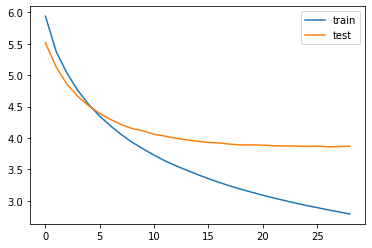

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현

In [41]:
#테스트 하기 전에 정수 인덱스 행렬로 존재하는 텍스트 데이터를 
#실제 데이터로 복원하기 위해 필요한 세 개의 사전 미리 준비해두기
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어 얻음

print('슝')

슝


In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [44]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


모델 테스트하기

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [46]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : anglo dutch oil gas giant shell wednesday said completed acquisition french oil major total stake port transaction shell equity interest gujarat based terminal terminal currently capacity million tonnes per annum 
실제 요약 : shell buys out total stake in and port 
예측 요약 :  oil firms to raise crore in oil and oil


원문 : bcci reportedly refused give discount rates match footage makers sachin tendulkar upcoming biopic sachin billion dreams production house said negotiating bcci footage already procured boards however sachin farewell speech provided free makers 
실제 요약 : bcci refuses to give discount on footage for sachin biopic 
예측 요약 :  bcci to play ipl after watching ipl biopic reports


원문 : french police recently shared photo drunk thief stuck shop window incident took place southwest france last week firefighters called free man later arrested photo shared caption drunk store gets stuck window arrested 
실제 요약 : french cops share photo of drunk thief stuck in shop window 
예측 요약 :  ma

예측 요약 :  online gst regulator to be held for food in


원문 : salman khan bodyguard shera guarding former boxing champion mike tyson visit india said american boxer ate liked chicken biryani took home traditional talking time spent american boxer shera said work salman khan handling celebrity becomes 
실제 요약 : tyson ate chicken biryani took home 
예측 요약 :  salman khan to get engaged to fight at salman


원문 : congress vice president rahul gandhi accidentally entered ladies toilet gujarat district interaction people sign outside toilets except poster gujarati read mate gandhi reportedly stepped wrong toilet could read gujarati 
실제 요약 : rahul gandhi mistakenly enters ladies toilet in gujarat 
예측 요약 :  rahul gandhi shares video of rahul gandhi


원문 : mohun bagan beat east bengal league sunday register first win team outside kolkata years mohun bagan within one point leaders aizawl fc game hand sony azharuddin scored mohun bagan east bengal plaza sent hitting player 
실제 요약 : beats east bengal i

예측 요약 :  spanish artist paints indonesian music festival


원문 : brihanmumbai municipal corporation asked mumbai mayor vishwanath mahadeshwar identify spots weekly farmer markets could set move aims provide direct platforms farmers sell produce comes farmers dumped produce officials stopped setting temporary stalls plot april 
실제 요약 : mumbai civic body plans to set up weekly farmer markets 
예측 요약 :  mumbai civic body to get cctvs to prevent parking


원문 : bollywood actor indian premier league side kolkata knight riders owner shah rukh khan revealed question answer session twitter miss former kkr captain gautam gambhir seven years gambhir requested side retain returned delhi daredevils playing first three editions 
실제 요약 : shah rukh khan admits he will miss gautam gambhir at kkr 
예측 요약 :  kkr rahul buys his ipl ipl after ipl auction




# 추출적 요약 해보기

In [47]:
import requests
from summa.summarizer import summarize

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [49]:
text = data['text']
text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [50]:
print('Summary:')
print(summarize(text[0], words=5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [51]:
# 리스트로 출력결과 받기
print('Summary:')
print(summarize(text[0], ratio=0.4, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [52]:
headlines = []
for i in range(len(text)):
    headline = summarize(text[i], ratio=0.4)
    headlines.append(headline)

In [54]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 헤드라인 :", data['headlines'][i])
    print("예측 헤드라인 :", headlines[i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인 : Users get one CRED coin per rupee of 